In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from Final_Data_Prep import remove_final_dummy, get_train_val_test, downsample

In [8]:
#read in data
total_df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

#remove final dummy column from each categorical column
remove_final_dummy(total_df)

#split into training, validation, and test sets
xtrain, xval, xtest, ytrain, yval, ytest = get_train_val_test (total_df,  0.7, 0.15, 0.15)
training_df = xtrain.join(ytrain)

#drop received_date column
total_df.drop(columns='received_date', inplace=True)

# passing 50 to downsample function means training set will have 50% positive cases
downsampled_training_df = downsample(training_df, 50)

X_train_down = downsampled_training_df.drop('MHI', axis=1)
y_train_down = downsampled_training_df['MHI']

In [9]:
'''
Random Forest Baseline with No Downsampling
No hyperparameter tuning, excludes engineered features
'''

non_baseline = ['402', 'weekday', 'incident_length', 'age_over_100', 'age_unknown', 'latitude', 'longitude',
                'season_fall', 'season_spring', 'season_summer', 'season_winter']

base_X_train = xtrain.drop(columns=non_baseline)
base_X_val = xval.drop(columns=non_baseline)

clf = RandomForestClassifier(random_state=2020, n_estimators=10).fit(base_X_train,ytrain)
y_pred_proba = clf.predict_proba(base_X_val)
y_pred = clf.predict(base_X_val)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)
print('AUC:', roc_auc)
print('Recall:', metrics.recall_score(yval, y_pred))

AUC: 0.5648597755210064
Recall: 0.0025188916876574307


In [10]:
'''
Random Forest Baseline with Downsampling
No hyperparameter tuning, excludes engineered features
'''

base_X_train_down = X_train_down.drop(columns=non_baseline)
base_X_val = xval.drop(columns=non_baseline)

clf = RandomForestClassifier(random_state=2020, n_estimators=10).fit(base_X_train_down,y_train_down)
y_pred_proba = clf.predict_proba(base_X_val)
y_pred = clf.predict(base_X_val)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)
print('AUC:', roc_auc)
print('Recall:', metrics.recall_score(yval, y_pred))

AUC: 0.7562405839077838
Recall: 0.6775818639798489


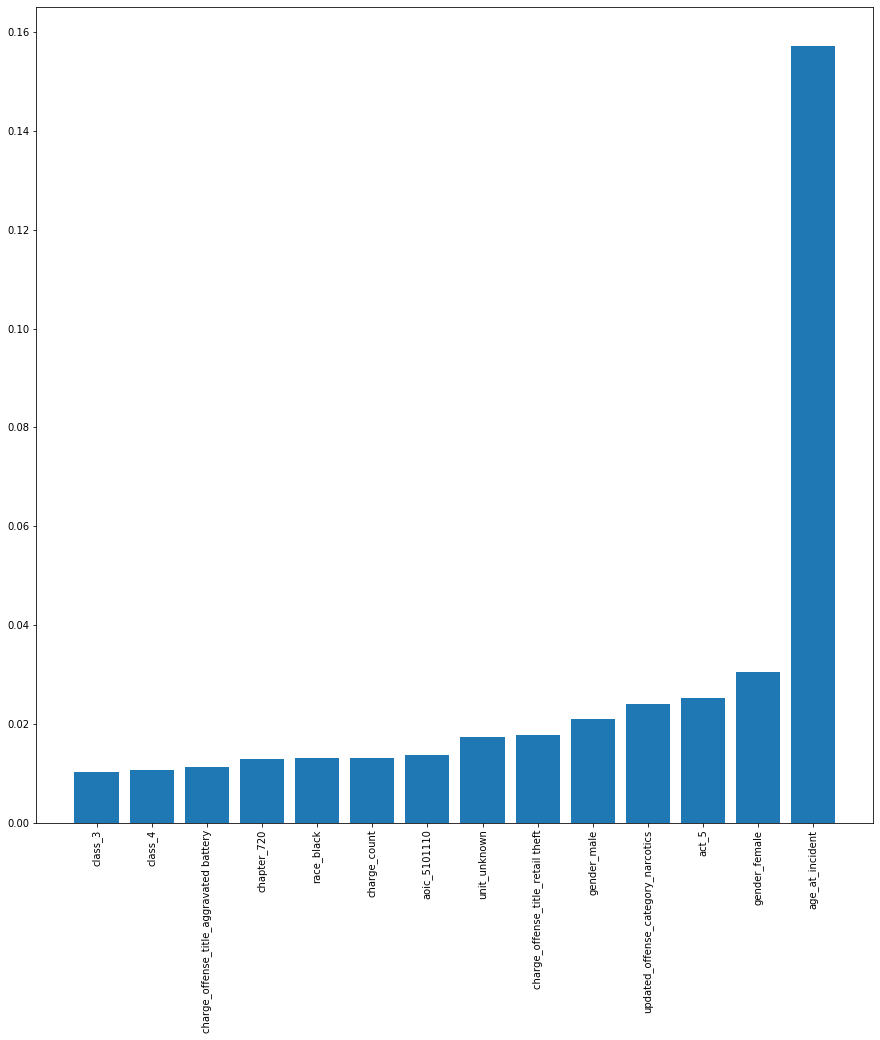

In [11]:
'''
Feature Importance Plot for Baseline Random Forest with Downsampling
'''

ftimp = [x for x in zip(base_X_train_down.columns, clf.feature_importances_)] #list of tuples
ftimp.sort(key = lambda x: x[1]) #sorting based on feature importance
ftimp = [x for x in ftimp if x[1] > 0.01] #theres a ton above 0
plt.figure(figsize=(15,15))
plt.bar(*zip(*ftimp)) #unzipping ftimp
plt.xticks(rotation='vertical')
plt.show()

In [6]:
#Won't run because of NaNs in ['weekday', 'latitude', 'longitude']

def RF_Tune(X_train, y_train, X_val, y_val, n_estimators, max_depths, min_samples_leafs):
    arrauc = np.zeros((len(n_estimators),len(max_depths),len(min_samples_leafs)))
    arrrec = np.zeros((len(n_estimators),len(max_depths),len(min_samples_leafs)))
    for n in range(len(n_estimators)):
        n_est = n_estimators[n]
        for d in range(len(max_depths)):
            max_dep = max_depths[d]
            for s in range(len(min_samples_leafs)):
                min_sam_leaf = min_samples_leafs[s]
                clf = RandomForestClassifier(random_state=2020, n_estimators = n_est, max_depth = max_dep, min_samples_leaf = min_sam_leaf)
                clf.fit(X_train,y_train)
                y_pred = clf.predict(X_val)
                y_pred_proba = clf.predict_proba(X_val)
                fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:,1])
                AUC_n_d_s = auc(fpr, tpr)
                recall = metrics.recall_score(y_val, y_pred)
                arrauc[n][d][s] = AUC_n_d_s
                arrrec[n][d][s] = recall
    return arrauc, arrrec

n_estimators = [10, 100, 500, 1000, 2000]
max_depths = [None, 5, 10, 15, 20, 30]
min_samples_leafs = [1, 2, 5, 10]

# n = 1000, max_depth = None, min_samples_leafs = 2 
rf_auc, rf_rec = RF_Tune(X_train_down, y_train_down, xval, yval, n_estimators, max_depths, min_samples_leafs)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
#Untested in current 2020 project iteration

print('Random Forest Performance after Hyperparameter Tuning')

print('Tested n_estimators= ', n_estimators, '\n')
print('Tested max_depths=', max_depths)
print('Tested min_samples_leafs= ', min_samples_leafs)

best_auc_ind = np.unravel_index(rf_auc.argmax(), rf_auc.shape)
print('Best AUC: ', np.max(rf_auc))
print('Recall at that level: ', rf_rec[best_auc_ind])
print('Parameters: n_estimators=', n_estimators[best_auc_ind[0]], 
      'max_depth=', max_depths[best_auc_ind[1]],
      'min_samples_leaf=', min_samples_leafs[best_auc_ind[2]], '\n')
print('test that this is working: best AUC is ', rf_auc[best_auc_ind], '\n')

best_rec_ind = np.unravel_index(rf_rec.argmax(), rf_rec.shape)
print('Best recall: ', np.max(rf_rec))
print('AUC at that level: ', rf_auc[best_rec_ind])
print('Parameters: n_estimators', n_estimators[best_rec_ind[0]], 
      'max_depth=', max_depths[best_rec_ind[1]],
      'min_samples_leaf=', min_samples_leafs[best_rec_ind[2]], '\n')
print('test that this is working: best recall is ', rf_rec[best_rec_ind], '\n')

both = rf_auc+rf_rec
best_both_ind = np.unravel_index(both.argmax(), both.shape)
print('Best combined (AUC+Recall): ', np.max(both))
print('Recall from combined: ', arrrec[best_both_ind])
print('AUC from combined: ', arrauc[best_both_ind])
print('Parameters: n_estimators', n_estimators[best_both_ind[0]], 
      'max_depth=', max_depths[best_both_ind[1]],
      'min_samples_leaf=', min_samples_leafs[best_both_ind[2]], '\n')